In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50, ResNet152
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import keras
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np
import tensorflow.keras
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
labels = ['Normal', 'hemorrhagic', 'ischemic', 'nonstroke']
img_size = 224

In [3]:
def get_data(data_dir):
    x, y=[],[]
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img)) #convert BGR to RGB format
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                resized_arr = cv2.resize(img_arr, (img_size, img_size), interpolation = cv2.INTER_LINEAR) # Reshaping images to preferred size
                x.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    return x,y

In [4]:
data_x, data_y = get_data('/kaggle/input/localdataclassification/classificationpng')
from sklearn.model_selection import train_test_split
Train_x, Val_x, Train_y, Val_y = train_test_split(data_x, data_y, test_size=0.2)

In [5]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
Val_x = np.array(Val_x)
Val_y = np.array(Val_y)

In [6]:
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip = True)  # randomly flip images
val_datagen= ImageDataGenerator()

In [7]:
Train_gen  = train_datagen.flow(Train_x, Train_y)
val_gen  = val_datagen.flow(Val_x, Val_y)

In [8]:
#SAMPLE IMAGE FROM TRAIN

Text(0.5, 1.0, 'hemorrhagic')

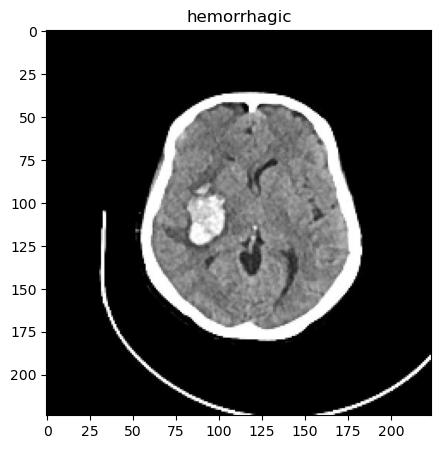

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(Train_x[0])
plt.title(labels[Train_y[0]])

In [10]:
Train_x.shape

(4484, 224, 224, 3)

In [11]:
Val_x.shape

(1121, 224, 224, 3)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPool2D
from tensorflow.keras.applications import ResNet50, ResNet152,ResNet152V2,VGG19

restnet = ResNet152(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in restnet.layers:
    layer.trainable = False
counter = 0
for layer in restnet.layers:
    counter+=1
    if counter == 5:
        break
    layer.trainable = True
output = restnet.output
output = GlobalMaxPool2D()(output)
output = Dense(512, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output = Dense(256, activation='relu')(output)
output = Dense(128, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output = Dense(4, activation = "softmax")(output)
restnet = Model(restnet.input, output)

234698864/234698864 [==============================] - 2s 0us/step


In [13]:
optimizer = keras.optimizers.Adam(lr=0.001)
restnet.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ['acc'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model_path = os.path.join("/kaggle/working/", "restnet_classifier.h5")
csv_path = os.path.join("/kaggle/working/", "restnet_classifier.csv")

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
# callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ]
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

In [16]:
history = restnet.fit(Train_gen,epochs=200, validation_data = val_gen)
restnet.save_result(model_path)

Epoch 1/200
141/141 [==============================] - 77s 406ms/step - loss: 1.7408 - acc: 0.5196 - val_loss: 0.8570 - val_acc: 0.6467
Epoch 2/200
141/141 [==============================] - 53s 377ms/step - loss: 0.8418 - acc: 0.6610 - val_loss: 0.7187 - val_acc: 0.7145
Epoch 3/200
141/141 [==============================] - 53s 377ms/step - loss: 0.7395 - acc: 0.7145 - val_loss: 0.9012 - val_acc: 0.6325
Epoch 4/200
141/141 [==============================] - 53s 377ms/step - loss: 0.6773 - acc: 0.7487 - val_loss: 0.6362 - val_acc: 0.7386
Epoch 5/200
141/141 [==============================] - 53s 377ms/step - loss: 0.6727 - acc: 0.7533 - val_loss: 0.6557 - val_acc: 0.7556
Epoch 6/200
141/141 [==============================] - 53s 377ms/step - loss: 0.6298 - acc: 0.7618 - val_loss: 0.6789 - val_acc: 0.7832
Epoch 7/200
141/141 [==============================] - 53s 376ms/step - loss: 0.5971 - acc: 0.7817 - val_loss: 0.5272 - val_acc: 0.8011
Epoch 8/200
141/141 [===========================

AttributeError: 'Functional' object has no attribute 'save_result'

In [17]:
restnet.save(model_path)

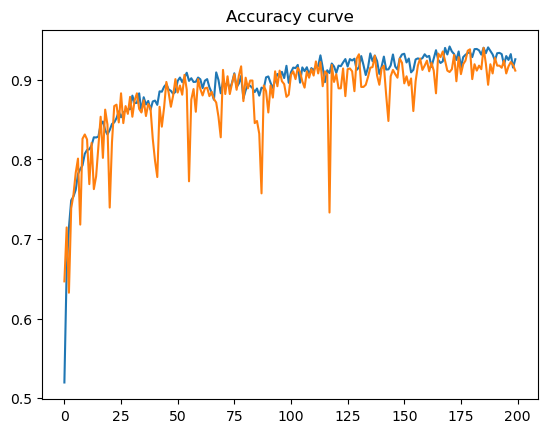

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy curve")
plt.show()

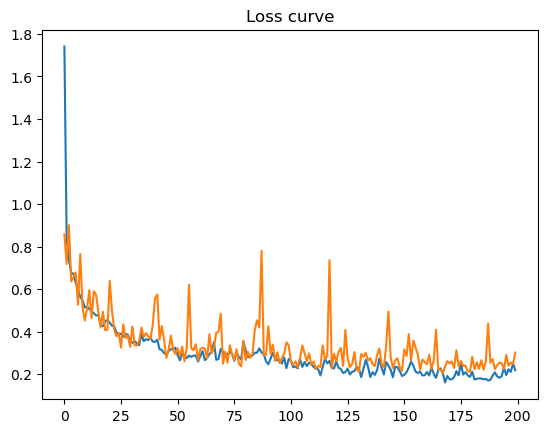

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss curve")
plt.show()

36/36 [==============================] - 7s 122ms/step


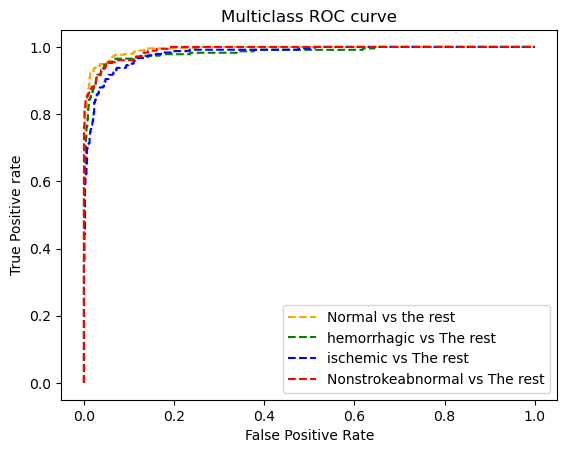

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob = restnet.predict(Val_x)
# pred_prob = restnet.predict_proba(Val_x)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(Val_y, pred_prob[:,i], pos_label=i)

# plotting    labels = ['Squamous cell carcinoma', 'Precancer', ' Normal','Adinocarcinoma']
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Normal vs the rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='hemorrhagic vs The rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='ischemic vs The rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Nonstrokeabnormal vs The rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)